# Final Project: Used Car Price Predictor
### Author: Satish Agrawal, Sanjay Jaras
### Bellevue University
### DSC 630 - Predictive Analytics

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpv
import types
import seaborn as sns
import sortedmap
import vaex as vx
from tqdm import tqdm

from sklearn import __version__ as sklv
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression

In [2]:
print('Using version %s of pandas' % pd.__version__)
print('Using version %s of numpy' % np.__version__)
print('Using version %s of matplotlib' % mpv)
print('Using version %s of seaborn' % sns.__version__)
print('Using version %s of sklearn' % sklv)

#print('Using version %s of sortedmap' % sortedmap.__version__)

Using version 1.2.0 of pandas
Using version 1.19.2 of numpy
Using version 3.3.2 of matplotlib
Using version 0.11.1 of seaborn
Using version 0.23.2 of sklearn
Using version {'vaex': '3.0.0', 'vaex-core': '2.0.3', 'vaex-viz': '0.4.0', 'vaex-hdf5': '0.6.0', 'vaex-server': '0.3.1', 'vaex-astro': '0.7.0', 'vaex-jupyter': '0.5.2', 'vaex-ml': '0.9.0', 'vaex-arrow': '0.5.1'} of pandas


## Configurations

In [3]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)

## Load Data
Data downloaded from https://www.kaggle.com/austinreese/craigslist-carstrucks-data

In [4]:
org_df = pd.read_csv("vehicles.csv", index_col=[0], converters={"cylinders":str})

In [5]:
org_df.shape 

(458213, 25)

In [6]:
org_df.info(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458213 entries, 0 to 458212
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            458213 non-null  int64  
 1   url           458213 non-null  object 
 2   region        458213 non-null  object 
 3   region_url    458213 non-null  object 
 4   price         458213 non-null  int64  
 5   year          457163 non-null  float64
 6   manufacturer  439993 non-null  object 
 7   model         453367 non-null  object 
 8   condition     265273 non-null  object 
 9   cylinders     458213 non-null  object 
 10  fuel          454976 non-null  object 
 11  odometer      402910 non-null  float64
 12  title_status  455636 non-null  object 
 13  transmission  455771 non-null  object 
 14  VIN           270664 non-null  object 
 15  drive         324025 non-null  object 
 16  size          136865 non-null  object 
 17  type          345475 non-null  object 
 18  pain

### Show Original Data types

In [7]:
org_df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object

### Create list of numeric and categorical columns

In [8]:
num_attr = ["year", "odometer", "lat", "long"]
cat_attr = ["region", "manufacturer", "model", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size", "paint_color", "state", "type"]

### Create Categories list to be used by OneHotEncoder

In [9]:
### Create Categories list to be used by OneHotEncoder

categories_map = {}
for attr in cat_attr:
    categories_map[attr] = org_df[attr].dropna().unique()
    categories_map[attr].sort()

In [10]:
categories_map["region"][:10]

array(['SF bay area', 'abilene', 'akron / canton', 'albany',
       'albuquerque', 'altoona-johnstown', 'amarillo', 'ames',
       'anchorage / mat-su', 'ann arbor'], dtype=object)

### Split Data in training Testing set

In [11]:
train_set, test_set = train_test_split(org_df, test_size=0.2, random_state=random_state)

In [12]:
train_set_copy = train_set.copy()

### Let's drop column that we will not be using

In [13]:
# dropping columns which are not directly correlated to the target variable
train_set = train_set.drop(columns=['url', 'id','image_url', 'description', 'region_url', 'VIN'])

In [14]:
train_set.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date
341103,pittsburgh,5985,2006.0,hyundai,azera,NaN,,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,pa,40.394280,-79.688988,2020-11-28T14:28:21-0500
295246,cincinnati,2000,1989.0,bmw,325i,NaN,6 cylinders,gas,207463.0,clean,automatic,NaN,NaN,coupe,black,oh,39.283900,-84.474400,2020-11-27T10:00:53-0500
428050,kenosha-racine,3999,2003.0,honda,accord,like new,4 cylinders,gas,134578.0,clean,automatic,fwd,NaN,sedan,NaN,wi,43.118800,-87.947800,2020-11-28T11:17:04-0600
31565,inland empire,229,2011.0,ford,ranger xlt,NaN,,gas,80506.0,clean,automatic,rwd,NaN,pickup,blue,ca,34.023568,-117.111767,2020-11-29T09:17:01-0800
18887,fayetteville,47995,2017.0,gmc,yukon xl denali 4x4 4dr suv,good,8 cylinders,gas,51031.0,clean,automatic,NaN,NaN,other,white,ar,36.203482,-94.138862,2020-11-06T11:47:42-0600


### Create Class for outlier extraction to be used in pipelin

In [15]:
class OutlierExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, attrmap ):
        self.attrmap = attrmap

    def transform(self, X):
        for attr in self.attrmap:
            val = self.attrmap[attr]
            min, max = X[attr].quantile([val[0], val[1]])
            X = X[(X[attr]>=min) & (X[attr]<=max)]
        return X

    def fit(self, X, y = None):
        return self

### Check distribution and outlier for years

In [16]:
train_set.year.describe()

count    365708.000000
mean       2010.745543
std           8.875581
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2016.000000
max        2021.000000
Name: year, dtype: float64

INFO:MainThread:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


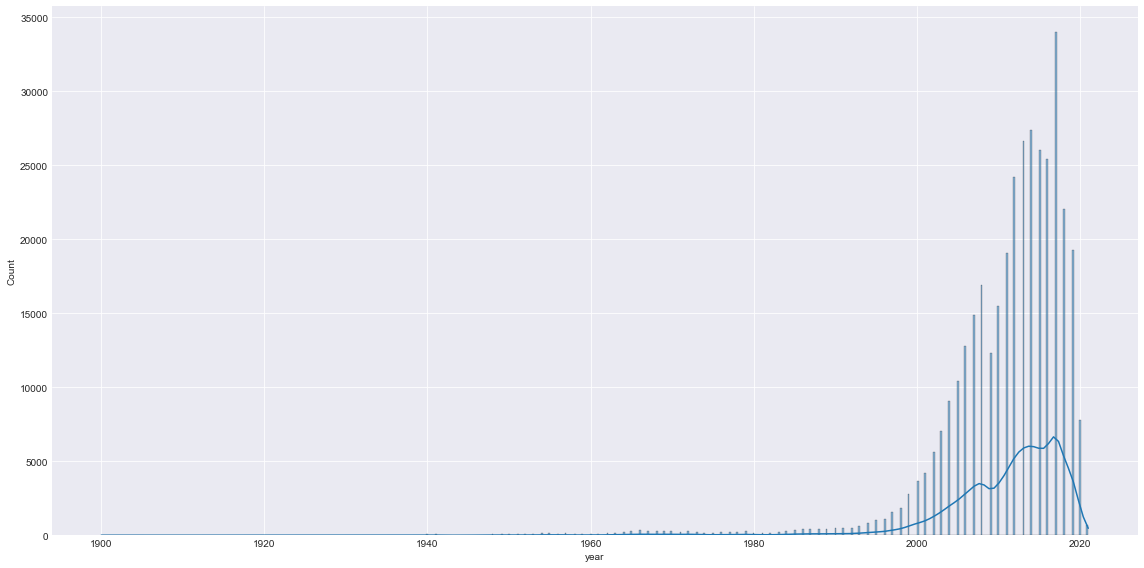

In [17]:
sns.displot(x=train_set.year, kde=True, height=8, aspect=2 )
plt.show()

### Drop outlier year records 

In [18]:
est = OutlierExtraction({"year":[0.10, 0.999]})
train_set = est.fit_transform(train_set)

### Year distribution after outlier removal

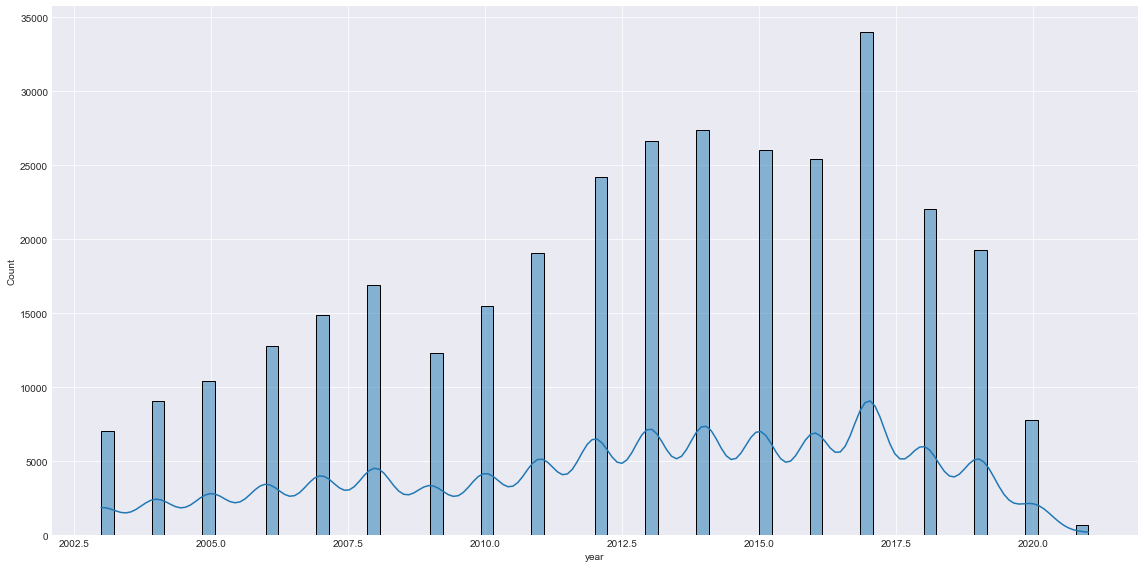

In [19]:
sns.displot(x=train_set.year, kde=True, height=8, aspect=2 )
plt.show()

### Check distribution and outlier for odometer

In [20]:
train_set.odometer.describe()

count    2.959580e+05
mean     9.888558e+04
std      3.764925e+06
min      0.000000e+00
25%      3.945300e+04
50%      8.423900e+04
75%      1.295708e+05
max      2.043756e+09
Name: odometer, dtype: float64

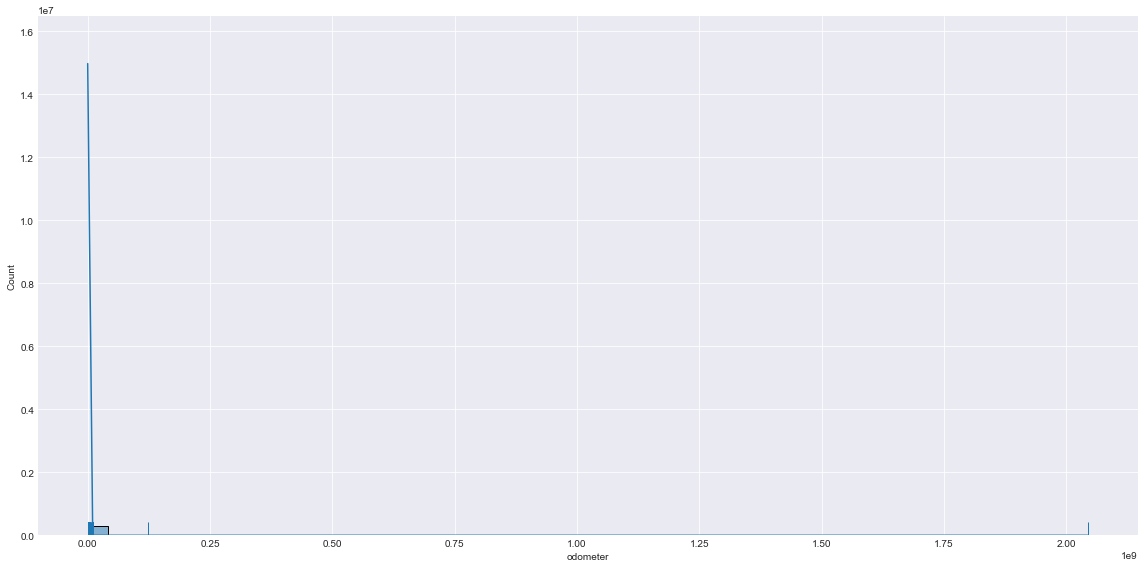

In [21]:
sns.displot(x=train_set.odometer, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Drop outlier odometer records 

In [22]:
est = OutlierExtraction({"odometer":[0, 0.90]})
train_set = est.fit_transform(train_set)

### Odometer distribution after outlier removal

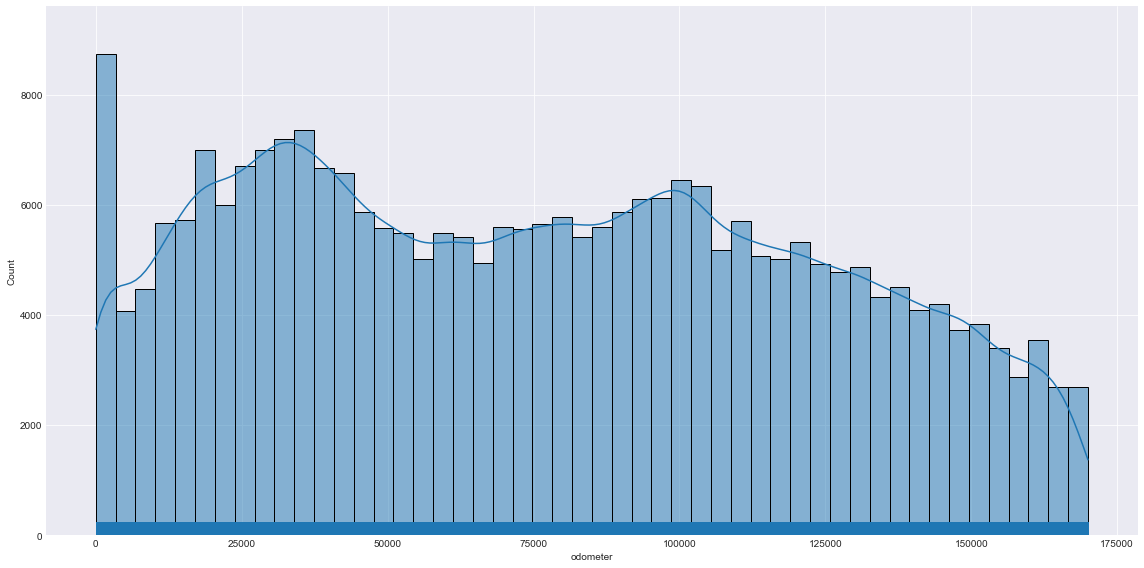

In [23]:
sns.displot(x=train_set.odometer, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Check distribution and outlier for price

In [24]:
train_set.price.describe()

count    2.663630e+05
mean     3.143320e+04
std      7.011650e+06
min      0.000000e+00
25%      6.700000e+03
50%      1.391800e+04
75%      2.471400e+04
max      3.615215e+09
Name: price, dtype: float64

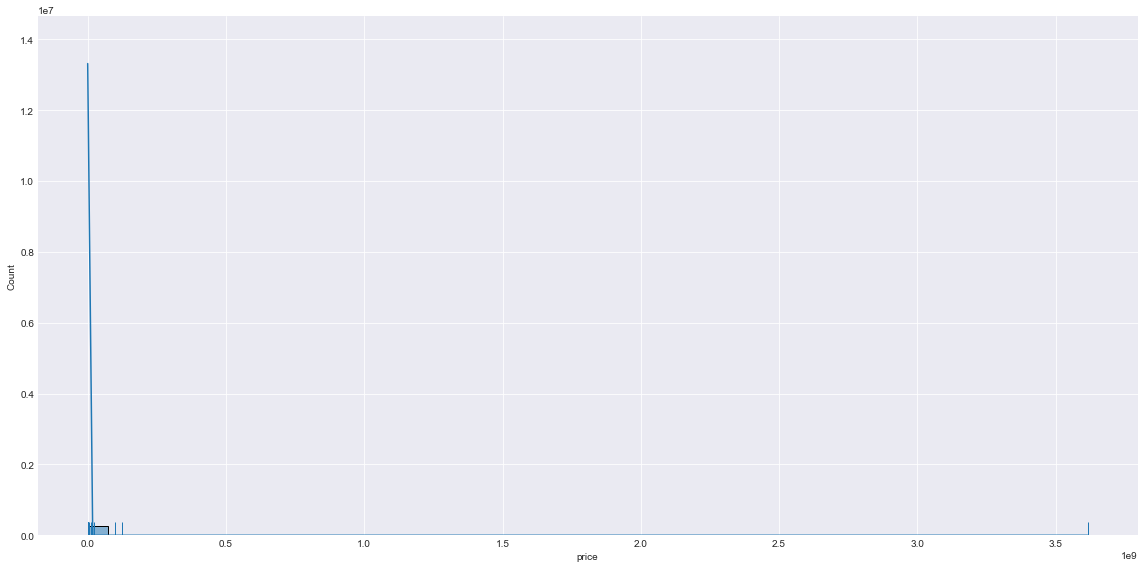

In [25]:
sns.displot(x=train_set.price, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Drop outlier price records 

In [26]:
est = OutlierExtraction({"price":[0.15, 0.95]})
train_set = est.fit_transform(train_set)

### Year distribution after outlier removal

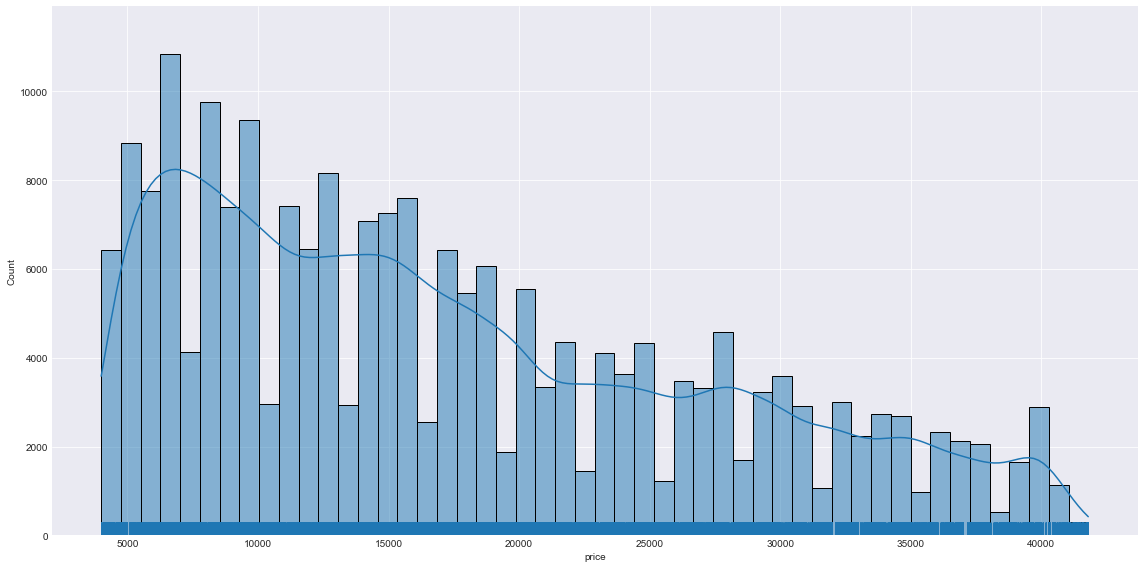

In [27]:
sns.displot(x=train_set.price, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Find Missing Values

### Some columns has blank values, let's replace them with nan

In [28]:
train_set.isnull().sum()

region               0
price                0
year                 0
manufacturer      4244
model              845
condition        81675
cylinders            0
fuel              1591
odometer             0
title_status       995
transmission       938
drive            51914
size            152415
type             35571
paint_color      49869
state                0
lat               1658
long              1658
posting_date         0
dtype: int64

In [29]:
test = train_set.cylinders[train_set.cylinders == ""]
test.count()

72859

In [30]:
class ReplaceBlankValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X):
        df = pd.DataFrame()
        for attr in range(X.shape[1]): 
            col = pd.Series(X[:, attr])
            col[col == ""] = np.NaN
            df[attr] = col.ravel()
        return df.to_numpy()

    def fit(self, X, y = None):
        return self

In [31]:
transfomer = ReplaceBlankValues()
df_temp = pd.DataFrame(transfomer.fit_transform(train_set.to_numpy()))
df_temp.columns = train_set.columns
train_set = df_temp

In [32]:
train_set.isnull().sum()

region               0
price                0
year                 0
manufacturer      4244
model              845
condition        81675
cylinders        72859
fuel              1591
odometer             0
title_status       995
transmission       938
drive            51914
size            152415
type             35571
paint_color      49869
state                0
lat               1658
long              1658
posting_date         0
dtype: int64

### Heatmap with null values

<AxesSubplot:>

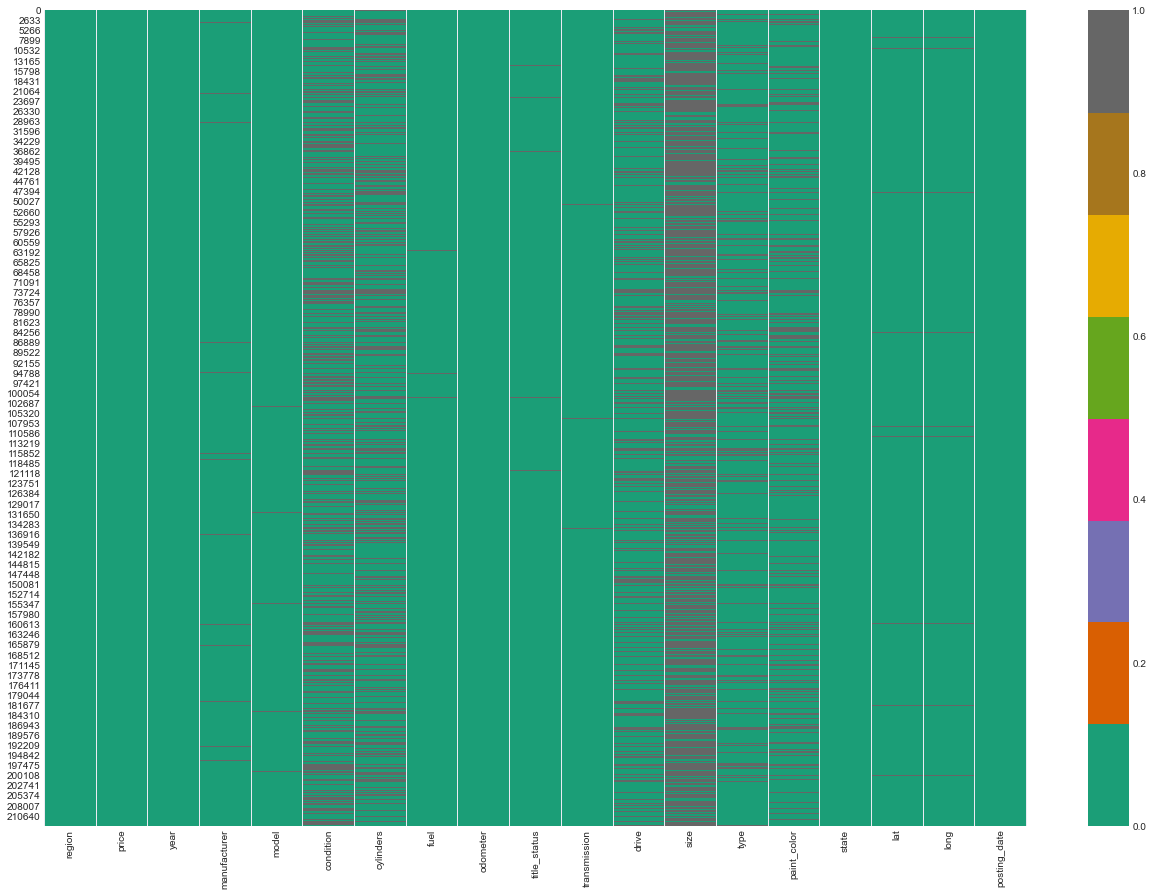

In [33]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.heatmap(train_set.isnull(), cmap="Dark2")

### Bar to find columns with missing values more than 50%

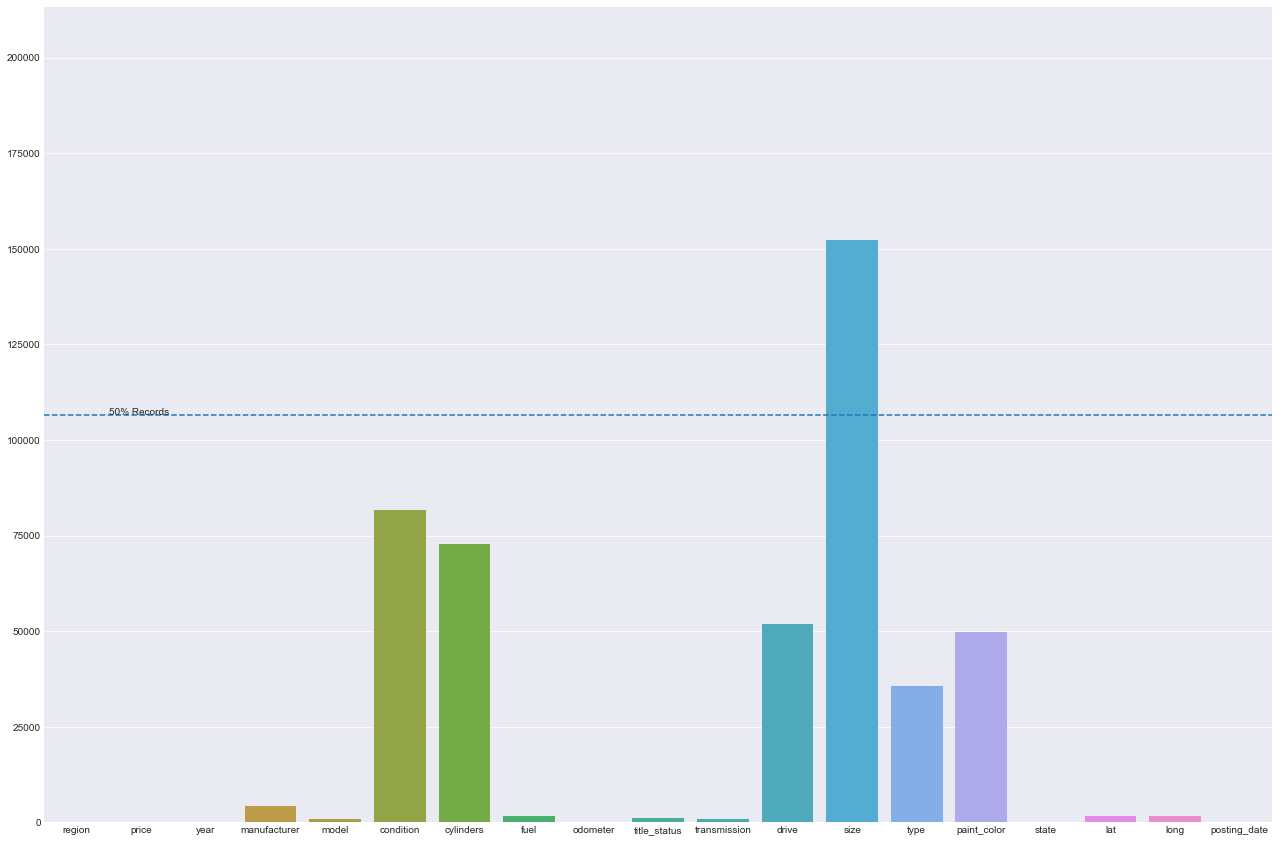

In [34]:
train_set.isnull().sum()
total = [len(train_set.index) for i in range(train_set.shape[1]) ]

fig, ax =plt.subplots(1,figsize=(22, 15))
g=sns.barplot(x=train_set.columns, y=train_set.isnull().sum())
ax1= g.axes
ax1.axhline(len(train_set.index)/2, ls='--')
ax1.text(0.5,len(train_set.index)/2, "50% Records")
plt.ylim(0, len(train_set.index))
plt.show()

### We can drop column size as it is having more than 50% missing values

In [35]:
train_set.drop(columns="size", inplace=True)

In [36]:
train_set.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date
0,kenosha-racine,3999,2003.0,honda,accord,like new,4 cylinders,gas,134578.0,clean,automatic,fwd,sedan,NaN,wi,43.118800,-87.947800,2020-11-28T11:17:04-0600
1,cape cod / islands,6499,2011.0,nissan,pathfinder,good,6 cylinders,gas,156300.0,clean,automatic,4wd,NaN,NaN,ma,41.673575,-70.266194,2020-11-13T12:20:33-0500
2,el paso,5600,2006.0,nissan,xterra,good,6 cylinders,gas,119000.0,clean,automatic,rwd,SUV,grey,tx,31.817096,-106.561892,2020-11-30T15:30:51-0700
3,ventura county,5995,2014.0,nissan,versa hatchback,excellent,4 cylinders,gas,84000.0,clean,automatic,NaN,NaN,silver,ca,34.226200,-118.447000,2020-11-07T09:23:12-0800
4,central michigan,11995,2007.0,chevrolet,avalanche,NaN,NaN,gas,114614.0,clean,automatic,NaN,NaN,NaN,mi,43.182400,-84.112200,2020-11-27T11:24:03-0500


### Let's use Simple Imputer with most_frequent strategy to fill missing values
We are using Simple Imputer with most frequent as we have categorical columns into data, other startegy will impute new values(categories)

### Create a class to fill missing values as Simple Imputer with most_frequent is too slow

In [37]:
class FillMissingValueWithMostFrequent(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X):
        df = pd.DataFrame()
        for attr in range(X.shape[1]): 
            col = pd.Series(X[:, attr])
            col.fillna(value=col.mode()[0], inplace=True)
            df[attr] = col.ravel()
        return df.to_numpy()

    def fit(self, X, y = None):
        return self
    

In [38]:
#selected_est = make_pipeline(SimpleImputer(missing_values=np.NaN, strategy="most_frequent"))
transfomer = FillMissingValueWithMostFrequent()
df_temp = pd.DataFrame(transfomer.fit_transform(train_set.to_numpy()))
df_temp.columns = train_set.columns
train_set = df_temp

### ### Add age column from model year and posting date

In [39]:
class AddAgeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, year_col_idx, posting_date_idx): # no *args or **kargs
        self.year_col_idx = year_col_idx
        self.posting_date_idx = posting_date_idx
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        inp = X.values
        post_date=pd.Series(pd.to_datetime(inp[:, self.posting_date_idx], utc=True))
        year = (inp[:, self.year_col_idx] - 1).astype(int).astype(str)
        manu_year=np.char.add(year, "/09/30")
        manu_date = pd.to_datetime(manu_year, format="%Y/%m/%d", utc=True)
        #ser = pd.Series(inp[:, self.posting_date_idx])
        #print(post_date.dtypes)
        diff = pd.to_datetime(post_date).subtract(manu_date)
        return np.c_[(diff/np.timedelta64(1, 'M'))]

In [40]:
attr_adder = AddAgeColumn(train_set.columns.get_loc("year"), train_set.columns.get_loc("posting_date"))
age_col = attr_adder.transform(train_set)

In [41]:
train_set["age_in_months"] = age_col
train_set.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,age_in_months
0,kenosha-racine,3999,2003.0,honda,accord,like new,4 cylinders,gas,134578.0,clean,automatic,fwd,sedan,white,wi,43.118800,-87.947800,2020-11-28T11:17:04-0600,217.982963
1,cape cod / islands,6499,2011.0,nissan,pathfinder,good,6 cylinders,gas,156300.0,clean,automatic,4wd,sedan,white,ma,41.673575,-70.266194,2020-11-13T12:20:33-0500,121.488248
2,el paso,5600,2006.0,nissan,xterra,good,6 cylinders,gas,119000.0,clean,automatic,rwd,SUV,grey,tx,31.817096,-106.561892,2020-11-30T15:30:51-0700,182.046879
3,ventura county,5995,2014.0,nissan,versa hatchback,excellent,4 cylinders,gas,84000.0,clean,automatic,4wd,sedan,silver,ca,34.226200,-118.447000,2020-11-07T09:23:12-0800,85.282226
4,central michigan,11995,2007.0,chevrolet,avalanche,good,6 cylinders,gas,114614.0,clean,automatic,4wd,sedan,white,mi,43.182400,-84.112200,2020-11-27T11:24:03-0500,169.947912


### distribution plot for age in months

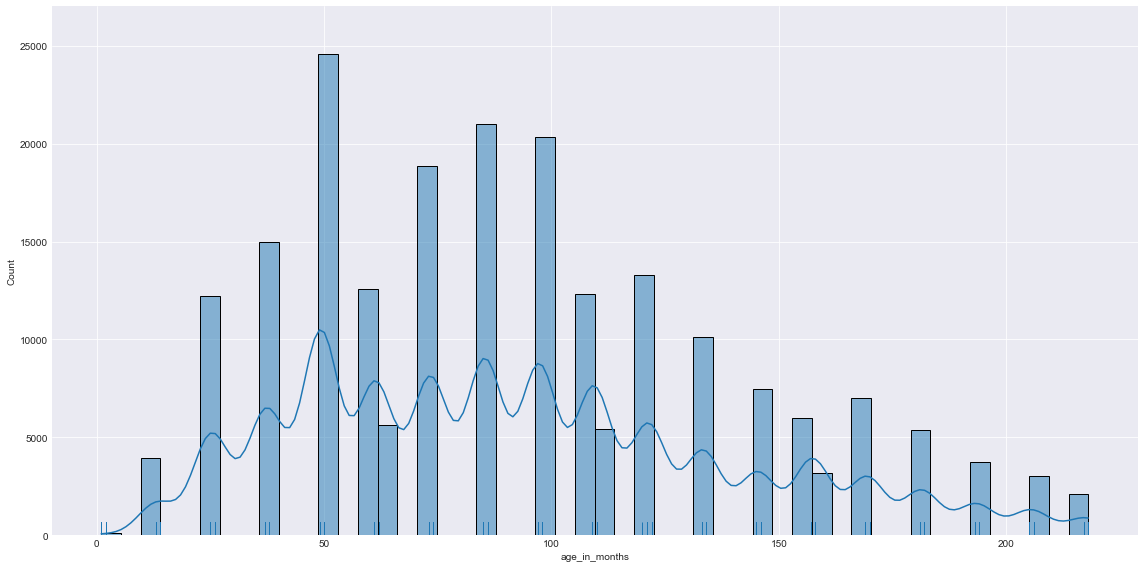

In [42]:
sns.displot(x=train_set.age_in_months.astype(int), kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Classes for Model Creation

### Class for removing column

In [43]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return  X[[b for b in list(X.columns) if b != self.attribute_name]]
        return X[self.attribute_names].values

drop_col = DropColumns("posting_date")
train_set = pd.DataFrame( drop_col.transform(train_set))

### Class for Column Selection

In [44]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
num_sel = ColumnSelector(num_attr)
df_num_attrs = num_sel.transform(train_set)

### Model Creation

### We will not use lat, lang, and state columns as they are redundant with region

In [45]:
num_attr = ["year", "odometer"]
cat_attr = ["region", "manufacturer", "model", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "paint_color", "type", "size", "state"]

In [46]:
est = OutlierExtraction({"price":[0.15, 0.95], "year":[0.10, 0.999],"odometer":[0, 0.90]})
train_set_copy = est.fit_transform(train_set_copy)

In [47]:
num_pipeline = Pipeline([('selector', ColumnSelector(num_attr)),
                         ('replace-blanks',ReplaceBlankValues()),
                         ('imputer', FillMissingValueWithMostFrequent()),                           
                         #('scaler', StandardScaler())
                        ])
test = num_pipeline.fit_transform(train_set_copy) 

In [48]:
add_age_pipeline = AddAgeColumn(train_set_copy.columns.get_loc("year"), train_set_copy.columns.get_loc("posting_date"))
age_col = add_age_pipeline.transform(train_set_copy)

### Class for Onehot encoding

In [49]:
class OneHotEncoderWithCategories(BaseEstimator, TransformerMixin):
    def __init__(self, categories, index):
        self.categories = categories
        self.index = index

    def transform(self, X):
        colval = X[:,self.index]
        encoder = OneHotEncoder(categories=self.categories)
        return encoder.fit_transform(colval.reshape(-1, 1))
        
    def fit(self, X, y = None):
        return self


class CombineOneHotEncodedCategories(BaseEstimator, TransformerMixin):
    def __init__(self, sorted_cat_map):
        self.sorted_cat_map = sorted_cat_map

    def transform(self, X):
        transformers = []
        i = 0
        for col in range(X.shape[1]): 
            cat = [self.sorted_cat_map[i]]
            #print("Cat", cat)
            encoder = OneHotEncoderWithCategories(cat, col)
            tup = (str(i), encoder)
            #print("encoder", encoder)
            transformers.append(tup)
            i += 1
        #print(transformers)
        cat_combine = FeatureUnion(transformer_list=transformers)    
        return cat_combine.fit_transform(X)

    def fit(self, X, y = None):
        return self

### Sort the categories to use with Onehot encoder

In [50]:
cat_map_sorted = sortedmap.sortedmap()
i =0 
for attr in cat_attr: 
    col = categories_map[attr]
    cat_map_sorted[i] = col.ravel()
    i += 1

In [51]:
cat_pipeline = Pipeline([('selector', ColumnSelector(cat_attr)),
                         ('replace-blanks',ReplaceBlankValues()),
                         ('imputer', FillMissingValueWithMostFrequent()), 
                         ('onehotEncoding', CombineOneHotEncodedCategories(cat_map_sorted))
                        ])
test2 = cat_pipeline.fit_transform(train_set_copy)

### Full Pipeline

In [52]:
full_pipeline = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
        ("num_pipeline", num_pipeline),
        ("add_age_col", add_age_pipeline)
    ])

train_prepared = full_pipeline.fit_transform(train_set_copy)
#df_for_split = pd.DataFrame(df_prepared)
#df_for_split["price"] = train_set_copy.price

### Feature Selection

In [53]:
#from sklearn import feature_selection
#feature_selection.chi2(train_prepared, train_set_copy.price)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#X = df_sel.drop(columns=["lat", "long"])
#X =X[X.transmission>=0]
#X =X[X.title_status>=0]
#X =X[X.drive>=0]
print(train_prepared.shape)
X_new = SelectKBest(score_func=chi2, k=20000).fit_transform(train_prepared, train_set_copy.price)
print(X_new.shape)

(219937, 32083)
(219937, 20000)


### Linear Regression

In [55]:
#some of models will predict neg values so this function will remove that values
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
def remove_neg(y_test,y_pred):
    ind=[index for index in range(len(y_pred)) if(y_pred[index]>0)]
    y_pred=y_pred[ind]
    y_test=y_test[ind]
    y_pred[y_pred<0]
    return (y_test,y_pred)

def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])

In [56]:
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_set_copy.price)

LinearRegression()

In [57]:
test_without_na = test_set.dropna()
test_prep = full_pipeline.fit_transform(test_without_na)
prediction = lin_reg.predict(test_prep)

In [58]:
y_test_1,y_pred_1=remove_neg(test_without_na.price.to_numpy(),prediction)
r1_lr=result(y_test_1,y_pred_1)
print('Coefficients: \n', lin_reg.coef_)
print("MSLE : {}".format(r1_lr[0]))
print("Root MSLE : {}".format(r1_lr[1]))
print("R2 Score : {} or {}%".format(r1_lr[2],r1_lr[3]))
accu['Linear Regression']=r1_lr

Coefficients: 
 [ 3.69066725e+02  4.30958451e+01  6.86415334e+02 ... -2.44141593e+03
 -4.84649438e-02 -2.96311391e+02]
MSLE : 7.6599911023083695
Root MSLE : 2.7676688931858107
R2 Score : 0.48411260633339803 or 48.4113%


## Grid Search

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

def performGridSearch(estimator, params):
    #for i in range(len(estimators)):
    print( "*" * 100)
    print("Evaluating Model", estimator)
    #https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
    #grid_clf = RandomizedSearchCV(estimators[i], param_grid[i], cv = cv, verbose = 2)
    grid_clf = GridSearchCV(estimator, param_grid=params, cv=cv, verbose=2)
    grid_clf.fit(train_prepared, train_set_copy.price)
    print("*" * 100)
    print("Best Score:", grid_clf.best_score_)
    print("Best Params:", grid_clf.best_params_)
    print("\n\n", "*" * 100)

In [65]:
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=random_state)

### Linear Regression 

In [66]:
model = LinearRegression(n_jobs=15)
params = {}
performGridSearch(model, params)

****************************************************************************************************
Evaluating Model LinearRegression(n_jobs=15)
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  ................................................................
[CV] ................................................. , total=   1.0s
[CV]  ................................................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[CV] ................................................. , total=   0.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
****************************************************************************************************
Best Score: 0.8673394696595771
Best Params: {}


 ****************************************************************************************************


In [68]:
param_grid = [
              {},
              {},
              {'learning_rate': [0.1, 0.3, 0.5], 'max_depth':[10, 20, 30], 'n_estimators':[100, 300, 500]},
              {'n_estimators':[100, 200, 300]},
             ]
estimators = [
              LinearRegression(n_jobs=15),
              DecisionTreeRegressor(random_state=random_state),
              XGBRegressor(n_jobs=15,gpu_id=0, objective='reg:squarederror'),
              RandomForestRegressor(n_jobs=15, random_state=random_state),
             ]
for i in range(len(estimators)):
    print( "*" * 100)
    print("Evaluating Model", estimators[i])
    #print(param_grid[i])
    #https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
    #grid_clf = RandomizedSearchCV(estimators[i], param_grid[i], cv = cv, verbose = 2)
    grid_clf = GridSearchCV(estimators[i], param_grid=param_grid[i], cv=cv, verbose=2, n_jobs=15)
    grid_clf.fit(train_prepared, train_set_copy.price)
    print("*" * 100)
    print("Best Score:", grid_clf.best_score_)
    print("Best Params:", grid_clf.best_params_)
    print("\n\n", "*" * 100)
    #print("Clf",estimators[i], "Score", grid_clf.score(test_prep, test_without_na.price))


****************************************************************************************************
Evaluating Model LinearRegression(n_jobs=15)
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   2 | elapsed:    2.4s finished
****************************************************************************************************
Best Score: 0.8673689414440094
Best Params: {}


 ****************************************************************************************************
****************************************************************************************************
Evaluating Model DecisionTreeRegressor(random_state=17)
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   2 | elapsed:   49.0s finished
*******************************

In [82]:
grid_clf.cv_results_

{'mean_fit_time': array([1987.76861167, 3161.05342114, 3707.53344262]),
 'std_fit_time': array([ 5.85776281, 18.00221574,  5.77094352]),
 'mean_score_time': array([2.29687011, 2.92214537, 1.52882147]),
 'std_score_time': array([0.12891829, 0.03800249, 0.15415812]),
 'param_n_estimators': masked_array(data=[100, 200, 300],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 100},
  {'n_estimators': 200},
  {'n_estimators': 300}],
 'split0_test_score': array([0.90405461, 0.90435215, 0.90450468]),
 'split1_test_score': array([0.9059593 , 0.90637338, 0.90655195]),
 'mean_test_score': array([0.90500695, 0.90536277, 0.90552832]),
 'std_test_score': array([0.00095234, 0.00101062, 0.00102363]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

In [72]:
import scipy
scipy.sparse.save_npz("train-set-X.csv", train_prepared, compressed=True)

In [76]:
train_set_copy.price.to_csv("train-set-Y.csv")

In [77]:
scipy.sparse.save_npz("test-set-X.csv", test_prep, compressed=True)

In [78]:
test_without_na.price.to_csv("test-set-Y.csv")